# Chest X-Ray Image Classification using PyTorch
# Summary

This project aims to categorize the chest images from an X-ray image dataset using PyTorch in three different classes; Normal, Viral Pneumonia, and COVID-19. 

The purpose of conducting this project is to learn the implementation of convolutional neural networks in PyTorch. This program shall not be used for diagnosis purposes. The primary source of this project is Amit Yadav's guided project on Coursera called [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray). In addition, the program has been modified by Romina Bahrami for self-studying purposes. 

The dataset is retrieved from  [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle.

# Importing Libraries

In [76]:
%matplotlib inline
#Operating System Interface which provides OS dependent functionality
import os

#Module for high-level file operations
import shutil

#Module for random number generating operations
import random

#Torch package
import torch

#Package consisting of some datasets, some model structures, image transformation methods
import torchvision

#Library for using mathematical functions and multi-dimensional arrays
import numpy as np

#Python Image Library for image manipulation
from PIL import Image

#Importing a collection of functions for plotting figures (similar to figures in MATLAB), from Python's plotting library
from matplotlib import pyplot as plt

#Setting the seed for generating random numbers
torch.manual_seed(0)

#HTTP library for url openning
import requests

#Displaying the PyTorch version being used
print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0


# Downloading and importing the data
The data can be downloaded from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database/download

In [77]:
#Assigning the path of the downloaded data
root_dir = os.path.abspath('COVID-19_Radiography_Dataset')
#printing the directory of the downloaded files
print(root_dir)

/home/romina/Documents/Coursera/Detecting COVID-19/COVID-19_Radiography_Dataset


# Preparing Training and Test Sets
A subset of the data needs to be chosen as the training set to train the model.
Another subset of the data will be used as the test set to test the trained model. 

In [78]:
# The data will be categorized in 3 categories 
class_names = ['normal', 'viral', 'covid']

# root_dir = 'COVID-19 Radiography Database'
# root_dir = '/path/to/your/downloaded/COVID-19 Radiography Database'

#The subfolders that being used (COVID-19 may need to be changed to COVID)
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

#Creating the test directory if not already created
look_for_test = os.path.isdir(os.path.join(root_dir, 'test'))
if look_for_test == False : 
    os.mkdir(os.path.join(root_dir, 'test'))

#if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
#    os.mkdir(os.path.join(root_dir, 'test'))

#for i, d in enumerate(source_dirs):
#        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
       
#Creating 3 categories inside the test directory
for c in class_names:
    #checking to see if the categories already exist
    if os.path.isdir(os.path.join(root_dir, 'test', c)) == False:
        os.mkdir(os.path.join(root_dir, 'test', c))
for i, c in enumerate(class_names):
        #Selecting all the png images in three directories
        images = [x for x in os.listdir(os.path.join(root_dir, source_dirs[i])) if x.lower().endswith('png')]
        #Choosing 30 random images from each category images
        selected_images = random.sample(images, 30)
        #Defining the initial and test directories and moving the random images to test directories
        for image in selected_images:
            source_path = os.path.join(root_dir, source_dirs[i], image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset
Defining a set of functions to access the files, get them, and transform them. 

In [79]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        #Getting all the images of a certain category
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        #Defining parameters in ChestXRayDataset class
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        #Getting all the images of all the categories
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    #Counting the numebr of images
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        #Choosing a random category
        class_name = random.choice(self.class_names)
        #Modifying the index based on the remainder 
        index = index % len(self.images[class_name])
        #Specifying the image
        image_name = self.images[class_name][index]
        #Specifying the image's path
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        #Converting the image to RGB format, which is a 3D array with three values for r,g, and b colors, for each pixel
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [80]:
#Using a chain of transforms on the training set using Compose
train_transform = torchvision.transforms.Compose([
    #Specifying the image size
    torchvision.transforms.Resize(size=(224, 224)),
    #Flipping the images horizontally with a certain probabiliy (the default probability is 0.5)
    torchvision.transforms.RandomHorizontalFlip(),
    #Converting the images to tensor
    torchvision.transforms.ToTensor(),
    #Changing the intensity range of the pixels by normalizing
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#Using a chain of transforms on the test set 
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Note: The dimension of a tensor image is (C x H x W) where C, H, and W represent the number of channels, height, and width, respectively. The size of a batch of tensor images is B x C x H x W, Where B represents the number of images in the batch.

# Prepare DataLoader

In [81]:
#Defining the directory of the training set which is the original files
train_dirs = {
    'normal': f'{root_dir}/Normal',
    'viral': f'{root_dir}/Viral Pneumonia',
    'covid': f'{root_dir}/COVID'
}
#Preparing the training data from the training directory, using the ChestXRayDataset functions and the transforming specifications we defined in the previous section 
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10012 normal examples
Found 1165 viral examples
Found 3436 covid examples


In [82]:
#Defining the directory of the test set which we made. 
test_dirs = {
    'normal': f'{root_dir}/test/normal',
    'viral': f'{root_dir}/test/viral',
    'covid': f'{root_dir}/test/covid'
}

#Preparing the test data from the test directory, using the ChestXRayDataset functions and the transforming specifications we defined in the previous section 
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 180 normal examples
Found 180 viral examples
Found 180 covid examples


In [83]:
#Specifying number of samples to load in each batch
batch_size = 6

#Loading batches of data and having the data reshuffled at every epoch
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2436
Number of test batches 90


# Data Visualization

In [84]:
#Defining the 3 categories for training set
class_names = train_dataset.class_names
print(class_names)

#Function for displaying the images, with three inputs; the image, its real category and its predicted category
def show_images(images, labels, preds):
    #Specifying the size of the figure
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        #Specifications of each out of 6 subplots
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        #Rearranging the order of the the arrays (0->1, 1->2, 2->0)
        image = image.numpy().transpose((1, 2, 0))
        #Average of pixel values
        mean = np.array([0.485, 0.456, 0.406])
        #Standard deviation
        std = np.array([0.229, 0.224, 0.225])
        #Adjusting the pixel values
        image = image * std + mean
        #Limiting the pixel values wihin 0 and 1
        image = np.clip(image, 0., 1.)
        #Displaying the image
        plt.imshow(image)
        #Defining color parameter
        col = 'green'
        #Changing the color to red when the prediction is wrong
        if preds[i] != labels[i]:
            col = 'red'
        #Labeling the x axis by the real category    
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        #Labeling the y axis by the predicted category
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    #Formatting the padding between and around the subplots to default values    
    plt.tight_layout()
    #Displaying the complete figure
    plt.show()

['normal', 'viral', 'covid']


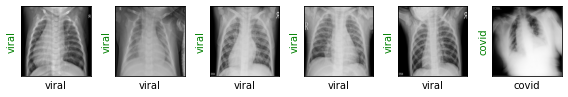

In [85]:
#Images of a batch of the training set
images, labels = next(iter(dl_train))
#Plotting the images of a batch of the training set
show_images(images, labels, labels)

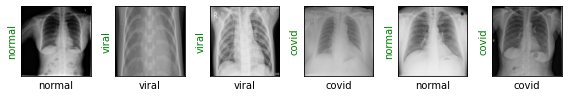

In [86]:
#Images of a batch of the test set
images, labels = next(iter(dl_test))
#Plotting the images of a batch of the test set
show_images(images, labels, labels)

# Creating the Model
torchvision.models.resnet18 provides a model for image classification, based on Deep Residual Learning for Image Recognition (https://arxiv.org/abs/1512.03385). We can use the pre-trained model which has been used to solve a similar problem as a satrting point. Then, we train the model by our own dataset and by making minor changes to the original model, we will make a trained model for our own dataset.

In [87]:
#Downloading the image classification model
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [88]:
#Applying a linear transformation to the data
    #in_features: size of each input sample
    #out_features: size of each output sample
    #bias: True by default -> The layer learns an additive bias
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

#The loss function for calculating the error
loss_fn = torch.nn.CrossEntropyLoss()
#Applying a stochastic optimization method with initial learning rate of 3e-5
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

Note: The concept of cross-entropy is used to define a loss function and calculate the difference among different probability distributions. 

Note: Adam is an optimization method derived from AMSprop and Stochastic Gradient Decent. It has some adavantages comparing to other stochastic optimization methods, because it computes separate adaptive learinign rates for individual parameters.

In [89]:
#Defining a function for predicting the results
def show_preds():
    #Setting the module on evaluation mode
    resnet18.eval()
    #Getting images from next test batch of the iteration
    images, labels = next(iter(dl_test))
    #Applying the model
    outputs = resnet18(images)
    #Value of maximum element along axis 1 with its predicted label
    _, preds = torch.max(outputs, 1)
    #Displaying the image and its original and predicted label
    show_images(images, labels, preds)

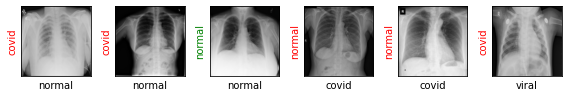

In [90]:
#Displaying the model's prediction prior to training
show_preds()

# Training the Model

In [91]:
#Defining the training function
def train(epochs):
    print('Starting training..')
    #epochs determines number of times going over the dataset
    for e in range(0, epochs):
        #Printing the fraction number of training interation between two double lines
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        
        #Defining the loss values
        train_loss = 0.
        val_loss = 0.
        #Switching the model to training mode
        resnet18.train() 
        #Implementing the step training method for updating the parameters
        for train_step, (images, labels) in enumerate(dl_train):
            #For each image, set the gradient to zero at the start of the training loop to avoid accumulation of gradient after multiple iterations
            optimizer.zero_grad()
            #Applying the training model to the data
            outputs = resnet18(images)
            #Calculating the error by applying the cross-entropy loss function to the original labels and the output of the training model distributions
            loss = loss_fn(outputs, labels)
            #Computing the gradient
            loss.backward()
            #Updating the parameters
            optimizer.step()
            #Extracting the training loss value as a float number and accumulate the values over iterations in a parameter
            train_loss += loss.item()
            #Displaying and evaluating every 20 training iterations
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                
                #Defining a parameter for representing the accuracy of the algorithm
                accuracy = 0
                #Switching the model to evaluation mode
                resnet18.eval() 
                #Using the test data for evaluation
                for val_step, (images, labels) in enumerate(dl_test):
                    #Applying the evaluating model which is already trained
                    outputs = resnet18(images)
                    #Calculating the error by applying the cross-entropy loss function to the original labels and the output of the evaluating model distribution
                    loss = loss_fn(outputs, labels)
                    #Extracting the evaluation loss value as a float number and accumulate the values over iterations in a parameter
                    val_loss += loss.item()
                    #Value of maximum element along axis 1 with its predicted label
                    _, preds = torch.max(outputs, 1)
                    #Counting the number of times where the prediction is correct
                    accuracy += sum((preds == labels).numpy())
                #The average validation loss
                val_loss /= (val_step + 1)
                #Efficiency 
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                #Displaying the prediction results
                show_preds()
                #Switching back to training mode after each evaluating iteration
                resnet18.train()
                #Breaking the training after 95% efficiency is reached
                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return
        #The average training loss
        train_loss /= (train_step + 1)
        #Displaying the updated average training loss if the targeted accuracy never reached
        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [92]:
#Measuring the user-cpu time, system-cpu time, and wall-clock time
%%time

train(epochs=1)

UsageError: Line magic function `%%time` not found.


# Results

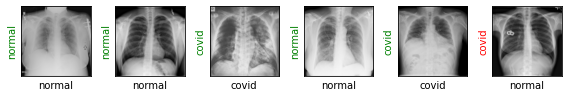

In [93]:
#Displaying the model's prediction after training
show_preds()

# Saving the Model

In [94]:
#Saving the learned parameters in the internal state dictionary 
torch.save(resnet18.state_dict(), 'covid_classifier.pt')

# Inference on a Single Image

In [95]:
#Loading the pre-trained model
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
#Loading the trained parameters from our training
resnet18.load_state_dict(torch.load('covid_classifier.pt'))
#Setting the model on evaluation mode
resnet18.eval()

#Defining a function for predicting the category of a single image
def predict_image_class(image_path):
    #Opening and converting the image to RGB format, which is a 3D array with three values for r,g, and b colors, for each pixel
    image = Image.open(image_path).convert('RGB')
    #Using a chain of transforms on the image with the specifications made earlier in the Image transformations section
    image = test_transform(image)
    #Adding a dimension to the image tensor at 0 position (for the index of class names)
    image = image.unsqueeze(0)
    #Applying the model to dimension 0
    output = resnet18(image)[0]
    #Applying a rescaling function along dimension 0 so that all the values are within 0,1, and sum to 1.
    probabilities = torch.nn.Softmax(dim=0)(output)
    #Moving the probabilty values from GPU memory to CPU-accessible memory; detaching (removing) the computational graph from the tensor; converting it to np.ndarray 
    probabilities = probabilities.cpu().detach().numpy()
    #Most probable predicted category's class index
    predicted_class_index = np.argmax(probabilities)
    #Class (category) name
    predicted_class_name = class_names[predicted_class_index]
    #Outputting the probability of each category, the predicted category and its associated index
    return probabilities, predicted_class_index, predicted_class_name

In [96]:
#Choosing a random category to pick up an image
class_name = random.choice(source_dirs)
#Defining the path to that category
image_path = root_dir +'/'+ class_name
#Making a set of all the images in that category
images = [x for x in os.listdir(image_path) if x.lower().endswith('png')]
#Choose a random image from that image set
image = random.choice(images)
print('Chosen image: ',image)
#Defining the path of that specific image
image_path = image_path + '/' + image

#image_path = '/path/to/image/to/test'
#Applying the predictive function to the single image
probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Chosen image:  Normal-2832.png
Probabilities: [0.41371575 0.26397556 0.32230866]
Predicted class index: 0
Predicted class name: normal


# Conclusion
The machine learning workflow implemented in PyTorch was used to train the ResNet-18 model with the chest X-ray images. The trained model was then successfully used to categorize the images with a minimum of 95% accuracy.


# References
[COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

[Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray)

[Gentle Introduction to the Adam Optimization Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

[optim.Adam vs optim.SGD](https://medium.com/@Biboswan98/optim-adam-vs-optim-sgd-lets-dive-in-8dbf1890fbdc)

[Python Cheatsheet](https://www.pythoncheatsheet.org/#The-Zen-of-Python)

[PyTorch Tutorials](https://pytorch.org/tutorials/)

[Transfer learning and the art of using Pre-trained Models in Deep Learning](https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/)
                    
[Transfer Learning with ResNet in PyTorch](https://www.pluralsight.com/guides/introduction-to-resnet)
                                      